In [169]:
import numpy as np
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import tqdm
import datetime

In [454]:
# Define hyperparameters for the tasks
T_stim = 8 # Stimulus duration
T_comp = 2 # Computation duration
T_plan = 2 # Planning duration
T_resp = 6 # Response duration
T_tot = T_stim + T_comp + T_plan + T_resp # Total trial duration
dt_inv = 4 # Number of time steps per time unit
assert int(dt_inv) == dt_inv, "dt_inv must be an integer"
dt = 1/dt_inv # Time step
T_steps = dt_inv*T_tot # Number of time steps per 
circular_input_dim = 36 # Number of input units around the circle
sample_orientations = torch.linspace(0, 2*np.pi, circular_input_dim + 1)[:-1]
task_input_dim = 0 # Number of input units for task
go_input_dim = 1
input_dim = circular_input_dim + go_input_dim + task_input_dim # Total number of input units
output_dim = 1 # Number of output units
kappa = 1 # Concentration parameter for the von Mises distribution

In [534]:
# In this cell we define the task function and sub-task functions
# This task function takes in:
# (1) A sub-task descriptor (a tuple of length 3)
# (2) The batch size (number of trials to be simulated) 
# This function returns:
# (1) The input sequence to the network, which has size (batch_size, T_steps, input_dim) 
# (2) The target output of the network, which has size (batch_size, T_steps, output_dim)

def task(task = (0,0,0), batch_size = 64, return_additional_info = False):
    subtask1, subtask2, subtask3 = task
    additional_info = {}
    # Define the input sequence
    X = torch.zeros(batch_size, T_steps, input_dim)
    # The go cue comes on at the start of the response period
    # The go cue is the input dimension after the circular input dimensions
    X[:,(T_stim+T_comp+T_plan)*dt_inv:,circular_input_dim] = 1
    # Define the target output sequence
    Y_tar = torch.zeros(batch_size, T_steps, output_dim)

    # First sample (i) the two stimuli (ii) the target direction (iii) the novel stimulus direction
    theta1 = torch.zeros(batch_size, 1)
    theta2 = torch.zeros(batch_size, 1)
    theta_tar = torch.zeros(batch_size, 1)
    theta_nov = torch.zeros(batch_size, 1)
    A1 = 0
    A2 = 0
    # Sampling depends on the second subtask (cognition)
    if subtask2 == 0:
        # This cognition subtask is get_max.
        # In this case, the two amplitudes are sampled from A_1 ~ U[0.4, 1] and A_2 ~ U[0.2, 0.8*A_1]
        A1 = torch.rand(batch_size, 1)*(1-0.4) + 0.4
        A2 = torch.rand(batch_size, 1)*(0.8*A1 - 0.2) + 0.2
        # The angles are sampled such that the minimum difference between them is \pi/4
        # This is done by first sampling \theta_1 uniformly from [0, 2\pi]
        # and then sampling \theta_2 uniformly from [\theta_1 + \pi/4, \theta_1 + 7\pi/4]
        theta1 = torch.rand(batch_size, 1)*2*np.pi
        theta2 = theta1 + torch.rand(batch_size, 1)*(3*np.pi/2) + np.pi/4 
        # Wrap the angles to be between 0 and 2\pi
        theta2 = torch.remainder(theta2, 2*np.pi)

        # Set target output direction - in this case, the direction with the larger amplitude
        theta_tar = theta1 

    # New computation task - weighted average. 

    
    # Define the input sequence for the first subtask (stimulus)
    if subtask1 == 0:
        # This stimulus subtask is integral load in.
        # In this case, the input sequence is the sum of two oscillating von Mises functions
        
        # Sample the phases of the oscillations
        phi1 = torch.rand(batch_size, 1)*2*np.pi
        phi2 = torch.rand(batch_size, 1)*2*np.pi

        # Sample the angular frequencies of the oscillations.
        # There are between 1 and 4 oscillations during the stimulus period.
        # This enforces that the angular frequencies are between 1 and 4 times (2\pi/T_stim) 
        omega1 = (torch.rand(batch_size, 1)*(4-1) + 1)*2*np.pi/T_stim
        omega2 = (torch.rand(batch_size, 1)*(4-1) + 1)*2*np.pi/T_stim
 
        # Construct the two bumps
        bump1 = A1[:,:,None]*torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,:]-theta1[:,None]))
        bump2 = A2[:,:,None]*torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,:]-theta2[:,None]))
        
        # Construct the temporal modulations
        t = torch.linspace(0, T_stim, T_stim*dt_inv + 1)[1:]
        t1 = omega1*t + phi1
        t2 = omega2*t + phi2
        t1 = t1[:,:,None]
        t2 = t2[:,:,None]
        modulation1 = torch.cos(t1)
        modulation2 = torch.cos(t2)

        # Construct the input sequence
        X[:,0:T_stim*dt_inv,0:circular_input_dim] = modulation1*bump1 + modulation2*bump2
    elif subtask1 == 1:
        # The stimulus task is the sequential load in.
        # In this case the two stimuli appear one after the other
        # Each stimulus occurs for half of the stimulus period
        
        # We randomise which stimulus appears first
        first_stim = torch.randint(0,2,(batch_size,1))
        # Iterate through the batch
        for epi in range(batch_size):
            if first_stim[epi] == 0:
                # Show (A1, theta1) first and then (A2, theta2)
                X[epi,0:int(T_stim*dt_inv/2),0:circular_input_dim] = A1[epi]*torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,:]-theta1[epi,None]))
                X[epi,int(T_stim*dt_inv/2):T_stim*dt_inv,0:circular_input_dim] = A2[epi]*torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,:]-theta2[epi,None]))
            else:
                # Show (A2, theta2) first and then (A1, theta1)
                X[epi,0:int(T_stim*dt_inv/2),0:circular_input_dim] = A2[epi]*torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,:]-theta2[epi,None]))
                X[epi,int(T_stim*dt_inv/2):T_stim*dt_inv,0:circular_input_dim] = A1[epi]*torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,:]-theta1[epi,None]))

    # Finally, set the correct output for the response phase
    if subtask3 == 0:
        # This response subtask is a discrepency estimation task. 
        # In this case, the output is the difference between the target and the novel stimulus directions
        # The output of the network is in [-1, 1], so we scale the difference to be in [-1, 1]
        
        # Set novel stimulus direction - in this case, uniformly sampled from [\theta_1 - 7\pi/8, \theta_1 + 7\pi/8]
        theta_nov = torch.rand(batch_size, 1)*(7*np.pi/4) + theta1 - 7*np.pi/8
        # Wrap the angles to be between 0 and 2\pi
        theta_nov = torch.remainder(theta_nov, 2*np.pi)
        # Set the input for the response and planning phases to be a von Mises bump centred at the novel stimulus direction
        X[:,(T_stim+T_comp)*dt_inv:,0:circular_input_dim] = torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,:]-theta_nov[:,None]))

        diff = torch.remainder(theta_tar - theta_nov, 2*np.pi)
        diff[diff > np.pi] = diff[diff > np.pi] - 2*np.pi
        Y_tar[:,(T_stim+T_comp+T_plan)*dt_inv:,0] = diff/np.pi
    elif subtask3 == 1:
        # This response subtask is a timing response task
        # A bump moves around the circle at a constant speed theta(t) 
        # The network must respond by creating a cosine output cos(theta(t) - theta_tar)

        # The angular velocity is sampled uniformly from [1,2] times (2\pi/T_resp)
        omega_nov = (torch.rand(batch_size)*(2-1) + 1)*2*np.pi/T_resp # omega has shape (batch_size, 1)
        # Randomly vary the sign of omega
        omega_nov = omega_nov*torch.sign(torch.rand(batch_size) - 0.5)
        # The initial angle is sampled uniformly from [0, 2\pi]
        phi_nov = torch.rand(batch_size)*2*np.pi # phi has shape (batch_size, 1)
        # The angular position is given by theta(t) = omega*t + phi
        t = torch.linspace(0, T_plan + T_resp, (T_plan+T_resp)*dt_inv + 1)[1:] # t has shape ((T_plan+T_resp)*dt_inv,)
        theta_nov = omega_nov[:,None]*t[None,:] + phi_nov[:,None] # theta_nov has shape (batch_size, (T_plan+T_resp)*dt_inv)
        # Wrap the angles to be between 0 and 2\pi
        theta_nov = torch.remainder(theta_nov, 2*np.pi)
        # Set the input for the response and planning phases to be a von Mises bump centred at the novel stimulus direction
        X[:,(T_stim+T_comp)*dt_inv:,0:circular_input_dim] = torch.exp(torch.distributions.von_mises.VonMises(0, kappa).log_prob(sample_orientations[None,None,:]-theta_nov[:,:,None]))
        # Set the target output to be the cosine of the difference between the novel stimulus direction and the target direction
        # First runcate theta_nov to be only over the response period
        theta_nov = theta_nov[:,-T_resp*dt_inv:] # theta_nov has shape (batch_size, T_resp*dt_inv)
        Y_tar[:,(T_stim+T_comp+T_plan)*dt_inv:,0] = torch.cos(theta_nov - theta_tar)
        additional_info['omega_nov'] = omega_nov 

    if return_additional_info:
        return X, Y_tar, additional_info
    else:   
        return X, Y_tar



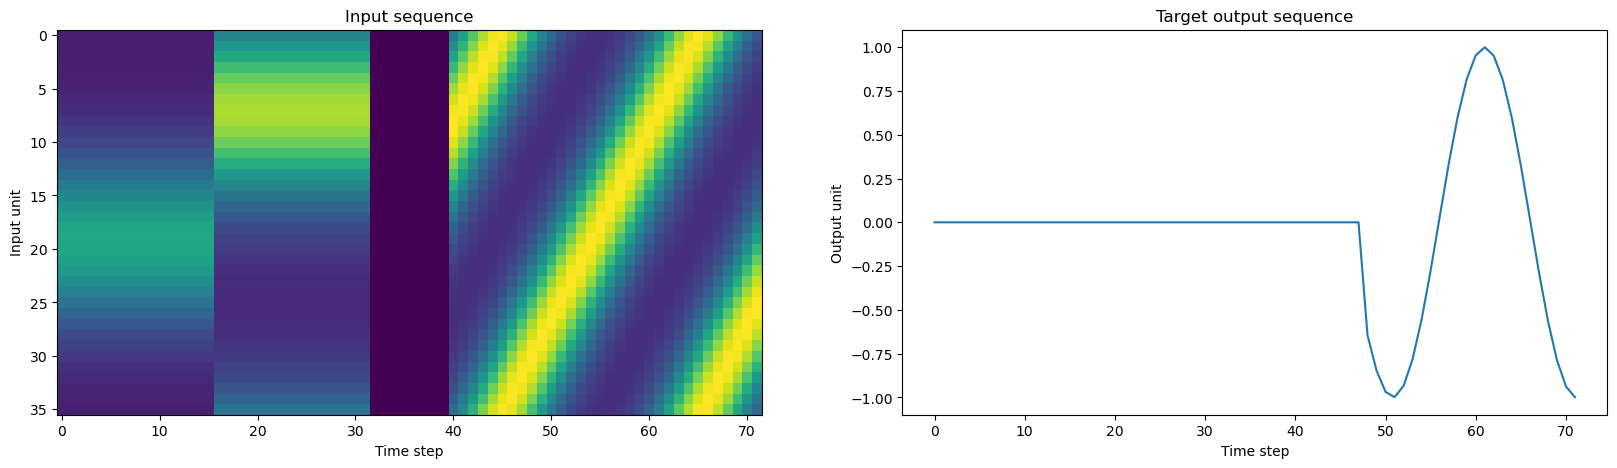

In [551]:
# plot a sample trial
X, Y_tar = task(task = (1,0,1), batch_size = 1)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(X[0,:,:circular_input_dim].T, aspect = 'auto')
plt.xlabel('Time step')
plt.ylabel('Input unit')
plt.title('Input sequence')
plt.subplot(1,2,2)
plt.plot(Y_tar[0,:,:])
plt.xlabel('Time step')
plt.ylabel('Output unit')
plt.title('Target output sequence')
plt.show()


In [457]:
# Set the network hyperparameters
N = 256 # Number of recurrent units
gam = 1e-6 # l1 regularization parameter
response_weight = 100 # Weight of the response and planning phase loss compared to the loss during the rest of the episode

In [552]:
# Set up the network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Layers = nn.ModuleDict({
            'input': nn.Linear(input_dim, N, bias = False),
            'recurrent': nn.Linear(N, N, bias = True),
            'output': nn.Linear(N, output_dim, bias = True)
        })

    def forward_one_step(self, x, h):
        # This method takes in the input x of size (batch_size, input_dim) for one time step
        # and the activities h of size (batch_size, N) from the previous time step.
        # The method returns the activies at the current time step, h_new of size (batch_size, N). 
        # and the output at the current time step, y of size (batch_size, output_dim).

        # Compute the activities at the current time step
        h_new = (1 - dt)*h + dt*F.relu(self.Layers['input'](x) + self.Layers['recurrent'](h))
        # Compute the output at the current time step
        y = self.Layers['output'](h_new) 
        return y, h_new
    
    def forward(self, X):
        # This method takes in a time series of inputs X of size (batch_size, T_steps, input_dim)
        # and returns the corresponding time series of outputs Y of size (batch_size, T_steps, output_dim)

        # Initialize the activities h of size (batch_size, N) to zero
        h = torch.zeros(X.shape[0], N)
        # Initialize the outputs Y of size (batch_size, T_steps, output_dim) to zero
        Y = torch.zeros(X.shape[0], X.shape[1], output_dim)
        # Loop over the time steps
        for t in range(X.shape[1]):
            # Compute the output and activities at the current time step
            y, h = self.forward_one_step(X[:,t,:], h)
            # Store the output at the current time step
            Y[:,t,:] = y
        return Y

In [553]:
def train_one_episode(model, optimiser, loss_function):
    # This method trains the network for one episode (one batch of trials)
    # It takes in the network model, the optimiser, and the loss function
    # It returns the loss for the episode

    # Set the gradients to zero
    optimiser.zero_grad()

    # Generate the input sequence and target output for the task
    # Train on a batch consisting of each subtask
    X0, Y_tar0 = task(task = (0,0,0), batch_size = 32)
    X1, Y_tar1 = task(task = (1,0,0), batch_size = 32)
    X2, Y_tar2 = task(task = (0,0,1), batch_size = 32)
    X3, Y_tar3 = task(task = (1,0,1), batch_size = 32)
    
    X = torch.cat((X0, X1, X2, X3), 0)
    Y_tar = torch.cat((Y_tar0, Y_tar1, Y_tar2, Y_tar3), 0)

    # Compute the output of the network
    Y = model.forward(X)

    # Compute the loss
    loss_pre = loss_function(Y[:,0:(T_stim+T_comp+T_plan)*dt_inv,:], Y_tar[:,0:(T_stim+T_comp+T_plan)*dt_inv,:])
    loss_response = loss_function(Y[:,(T_stim+T_comp+T_plan)*dt_inv:,:], Y_tar[:,(T_stim+T_comp+T_plan)*dt_inv:,:])
    loss = loss_pre + response_weight*loss_response
    # Compute the l1 penalty
    l1_penalty = model.Layers['recurrent'].weight.abs().sum() + model.Layers['output'].weight.abs().sum() + model.Layers["input"].weight.abs().sum()
    # Compute the total loss
    total_loss = loss + gam*l1_penalty
    # Perform gradient descent
    total_loss.backward()
    # Clip the gradients by the norm
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimiser.step()
    return loss


In [554]:
# Set up the network, optimiser, and loss function
my_net = Net()
optimiser = optim.Adam(my_net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [555]:
losses = []

In [556]:
# Train the network for 1000 episodes
losses = list(losses)
for i in tqdm.tqdm(range(2000)):
    loss = train_one_episode(my_net, optimiser, loss_function)
    losses.append(loss.detach().numpy())

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [07:41<00:00,  4.33it/s]


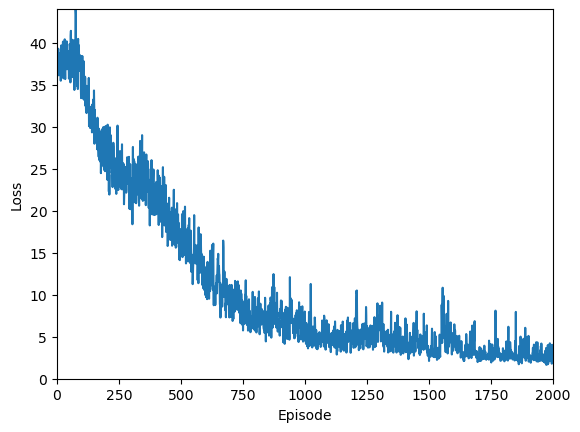

In [557]:
# Plot the losses
plt.plot(losses)
plt.xlabel('Episode')
plt.xlim([0, len(losses)])
plt.ylabel('Loss')
plt.ylim([0, max(losses)])
plt.show()

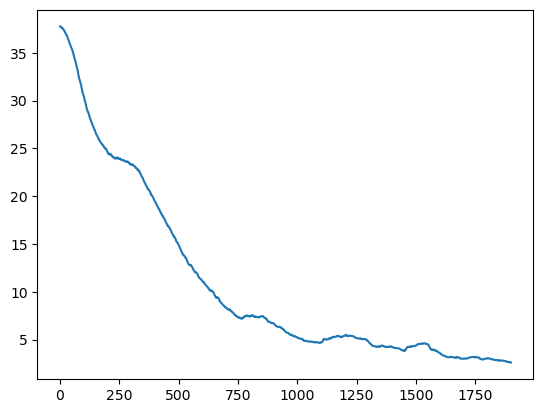

In [558]:
# Plot a running average of the losses
plt.plot(np.convolve(losses, np.ones(100)/100, mode = 'valid'))

In [559]:
# Find the average loss over the last 1000 time steps
losses = np.array(losses)
print('Average loss over last 1000 episodes: ', np.mean(losses[-1000:]))


Average loss over last 1000 episodes:  4.1009502


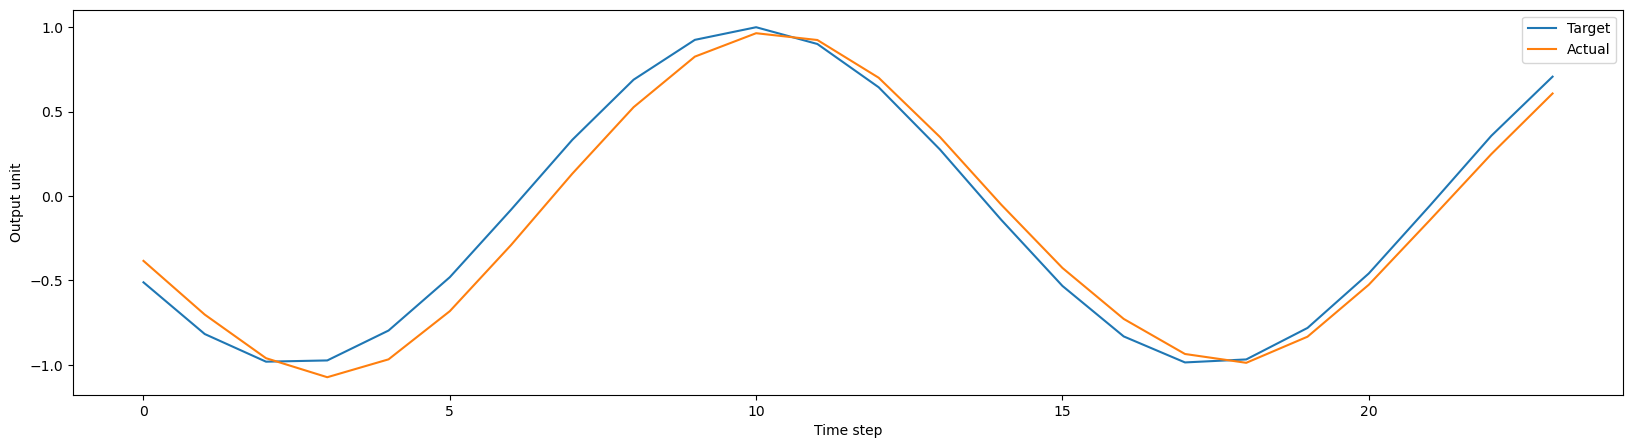

In [550]:
# Plot the network's performance on a sample batch. 
# We only care about the network's response during the response phase. 
# We plot a scatter plot of the networks performance against the frequency of oscillation of the novel stimulus

# Generate the input sequence and target output for the task
X, Y_tar = task(task = (1,0,1), batch_size = 1, return_additional_info = False)
# Retrieve the novel stimulus frequency 
# Compute the output of the network
Y = my_net.forward(X)

# Plot the target and actual output of the network over the response period
plt.figure(figsize=(20,5))
plt.plot(Y_tar[0,(T_stim+T_comp+T_plan)*dt_inv:,:].detach().numpy(), label = 'Target')
plt.plot(Y[0,(T_stim+T_comp+T_plan)*dt_inv:,:].detach().numpy(), label = 'Actual')
plt.xlabel('Time step')
plt.ylabel('Output unit')
plt.legend()
plt.show()



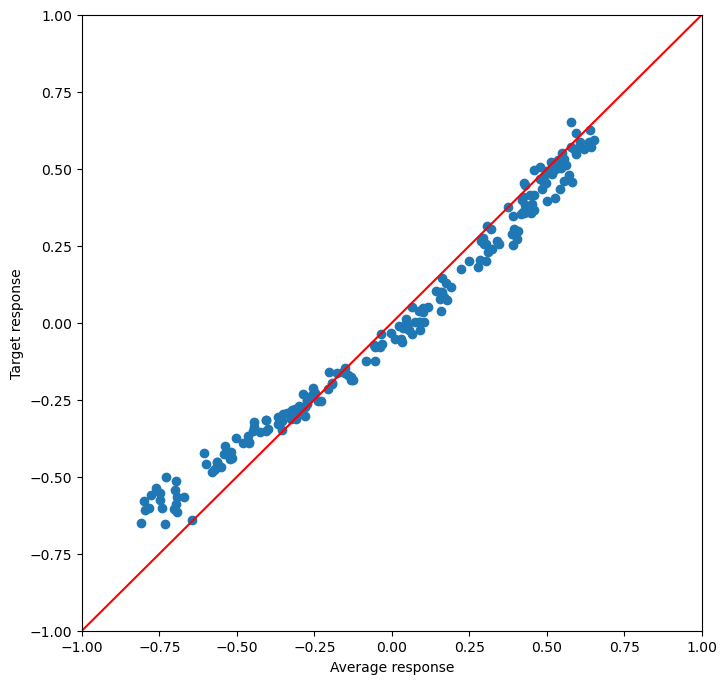

In [532]:
# Plot the network's performance on a sample batch. 
# We only care about the network's response during the response phase. 
# We plot a scatter plot of the network's average response vs. the target response.

# Generate the input sequence and target output for the task
X, Y_tar = task(task = (1,0,0), batch_size = 200)
# Compute the output of the network
Y = my_net.forward(X)
# Compute the average response during the response phase
Y_avg = Y[:,(T_stim+T_comp)*dt_inv:,:].mean(dim = 1)
# Compute the target response during the response phase
Y_tar = Y_tar[:,(T_stim+T_comp)*dt_inv:,:].mean(dim = 1)
# Plot the scatter plot
plt.figure(figsize=(8,8))
plt.scatter(Y_avg.detach().numpy(), Y_tar.detach().numpy())
plt.xlabel('Average response')
plt.ylabel('Target response')
# Add in the diagonal line
plt.plot([-1,1],[-1,1], 'r')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()


In [284]:
# Save the weights of the model
torch.save(my_net.state_dict(), 'model_weights_{}.pt'.format(datetime.datetime.now().strftime("%m%d_%H%M")))